In [50]:
import news_nlp.config.paths as paths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

import numpy.linalg as LA
import joblib
import random

from dotenv import load_dotenv
from news_nlp.topics_detector.topics_naming import (
	load_prompt_from_yaml,
	infer_llm
)
import os
import json

In [58]:
# Global config
RANDOM_SEED = 31415

# Parameters TF-IDF
TFIDF_BEST_MAX_FEATURES = 30_000
TFIDF_BEST_MIN_DF = 5
TFIDF_BEST_MAX_DF = 0.7
TFIDF_BEST_NGRAM_RANGE = (1, 2)
# Parameters SVD
SVD_BEST_N_COMPONENTS = 5
# Parameters KMeans
KMEANS_BEST_N_CLUSTERS = 30
# Parameters Topics naming
N_TOP_TERMS = 50

# Load data

In [105]:
df_train = pd.read_parquet(paths.DF_TRAIN_CLEAN)
df_train

,id_news,title,content,text,len_text
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"Singer, activist Joan Baez becomes Kennedy Cen...",177
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'Nothing but problems': Shipwreck tear-down en...,5332
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,Report: At least 13 dead in Istanbul bombings....,248
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,Senate Republicans Pressure Joe Biden to Withd...,4920
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,The Unwelcome Return of the Real Purveyors of ...,3894
...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,An Interview with Mark Blaxill on the Autism T...,1998
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,Vietnam reconsiders methane-emitting rice amid...,9005
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,Shaker furniture: Clean by design. The Hancock...,262
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",2093


In [4]:
# Extract column "text" as a list of strings, to be used for TF-IDF vectorization
texts = df_train["text"].astype(str).tolist()
len(texts)

89928

# Vectorization with TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) transforms each document in a numerical vector where each dimension is a word, and its value (its TF-IDF score) indicates the importance of that word in the document relative to the entire corpus.

## Full-vocabulary vectorization

In [5]:
# TF-IDF Vectorizer configuration
tfidf_full = TfidfVectorizer(
#     ngram_range=(1, 2),      # unigrams and bi-grams
#     stop_words="english",
#     min_df=5,                # at least in 5 documents
#     max_df=0.7               # discards very frequent terms
	max_features=None
)

In [6]:
X_full = tfidf_full.fit_transform(texts)
X_full.shape

(89928, 158998)

In [7]:
vocab_full = tfidf_full.get_feature_names_out()
vocab_full

array(['00', '000', '0000', ..., '晏宏', '温麟衍', 'ﬁle'],
      shape=(158998,), dtype=object)

In [8]:
term_freq = np.asarray(X_full.sum(axis=0)).ravel()
term_freq

array([4.69435942e+01, 5.39258810e+02, 9.05058664e-01, ...,
       4.82312353e-02, 1.67345636e-01, 1.04451748e-01], shape=(158998,))

In [9]:
sorted_idx = np.argsort(-term_freq)
freq_sorted = term_freq[sorted_idx]
vocab_sorted = vocab_full[sorted_idx]
vocab_sorted

array(['the', 'to', 'of', ..., 'crystallizes', 'monosodium',
       'candymakers'], shape=(158998,), dtype=object)

In [10]:
total_freq = freq_sorted.sum()
total_freq

np.float64(793884.1018772459)

In [11]:
coverage = np.cumsum(freq_sorted) / total_freq
coverage

array([0.01685862, 0.02649397, 0.03464927, ..., 0.99999999, 1.        ,
       1.        ], shape=(158998,))

In [12]:
def features_for_coverage(coverage_array, target):
	return int(np.searchsorted(coverage_array, target) + 1)

In [13]:
n_90 = features_for_coverage(coverage, 0.90)
n_95 = features_for_coverage(coverage, 0.95)
n_99 = features_for_coverage(coverage, 0.99)
n_999 = features_for_coverage(coverage, 0.999)
print(f"Number of features to cover 90% of the corpus: {n_90}")
print(f"Number of features to cover 95% of the corpus: {n_95}")
print(f"Number of features to cover 99% of the corpus: {n_99}")
print(f"Number of features to cover 99.9% of the corpus: {n_999}")

Number of features to cover 90% of the corpus: 15488
Number of features to cover 95% of the corpus: 28766
Number of features to cover 99% of the corpus: 76037
Number of features to cover 99.9% of the corpus: 136456


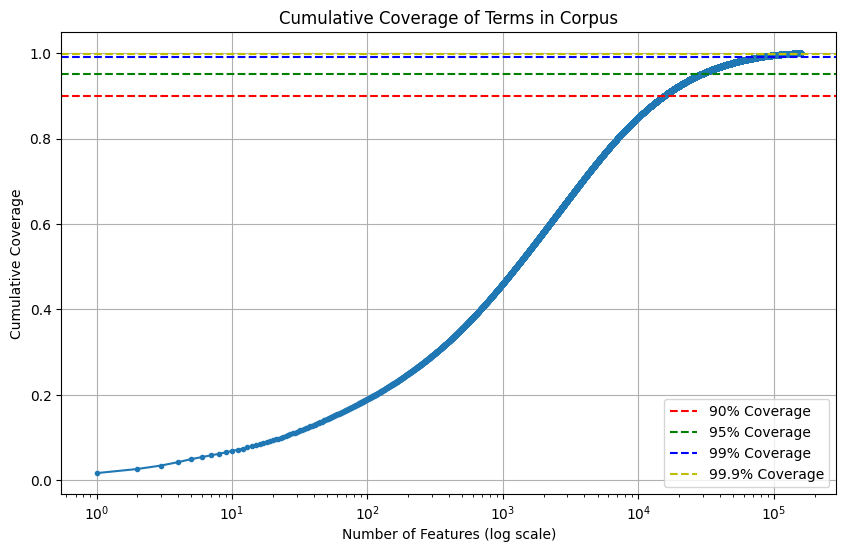

In [14]:
# Plot coverage curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(coverage) + 1), coverage, marker='.')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Coverage')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Coverage')
plt.axhline(y=0.99, color='b', linestyle='--', label='99% Coverage')
plt.axhline(y=0.999, color='y', linestyle='--', label='99.9% Coverage')
plt.xscale('log')
plt.xlabel('Number of Features (log scale)')
plt.ylabel('Cumulative Coverage')
plt.title('Cumulative Coverage of Terms in Corpus')
plt.legend()
plt.grid(True)
plt.show()

## Final vectorizer

In [15]:
# TF-IDF Vectorizer configuration
tfidf = TfidfVectorizer(
	max_features=MAX_FEATURES,  # Limits to top 30k features
	ngram_range=(1, 2),      	# Vocabulary including one-word and two-word terms (e.g., "climate", "climate change")
	stop_words="english",	 	# Removes common English stop words (e.g., "the", "is", "and")
	min_df=5,                	# Words must appear in at least 5 documents to be included
	max_df=0.7               	# Words that appear in more than 70% of documents are discarded
)

In [16]:
# Fit and transform the texts to obtain the TF-IDF matrix
X_tfidf = tfidf.fit_transform(texts)
X_tfidf.shape

(89928, 30000)

In [17]:
# Get feature names (words)
tfidf.get_feature_names_out()

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

In [41]:
def bot_terms_for_cluster(X_tfidf, feature_names, n_terms=15):
	"""
	Get the top n_terms with highest average TF-IDF score in the given cluster_id.
	Args:
		X_tfidf (sparse matrix): TF-IDF matrix.
		labels (array-like): Cluster labels for each document.
		topic_id (int): Cluster ID to analyze.
		n_terms (int): Number of top terms to return.
	Returns:
		list: Top n_terms feature names for the cluster.
	"""
	# suma de tfidf en el cluster
	tfidf_mean = np.asarray(X_tfidf.mean(axis=0)).ravel()
	top_idx = tfidf_mean.argsort()[::][:n_terms]
	return [feature_names[i] for i in top_idx]

In [43]:
def top_terms_for_cluster(X_tfidf, feature_names, n_terms=15):
	"""
	Get the top n_terms with highest average TF-IDF score in the given cluster_id.
	Args:
		X_tfidf (sparse matrix): TF-IDF matrix.
		labels (array-like): Cluster labels for each document.
		topic_id (int): Cluster ID to analyze.
		n_terms (int): Number of top terms to return.
	Returns:
		list: Top n_terms feature names for the cluster.
	"""
	# suma de tfidf en el cluster
	tfidf_mean = np.asarray(X_tfidf.mean(axis=0)).ravel()
	top_idx = tfidf_mean.argsort()[::-1][:n_terms]
	return [feature_names[i] for i in top_idx]

In [45]:
# TF-IDF Vectorizer configuration
tfidf = TfidfVectorizer(
	max_features=30_000,  # Limits to top 30k features
	ngram_range=(1, 2),      	# Vocabulary including one-word and two-word terms (e.g., "climate", "climate change")
	stop_words="english",	 	# Removes common English stop words (e.g., "the", "is", "and")
	min_df=5,                	# Words must appear in at least 5 documents to be included
	max_df=0.7               	# Words that appear in more than 70% of documents are discarded
)

# Fit and transform the texts to obtain the TF-IDF matrix
X_tfidf = tfidf.fit_transform(texts)
X_tfidf.shape

feature_names = list(tfidf.get_feature_names_out())
# Get features names with the lowest scores
print(bot_terms_for_cluster(X_tfidf, feature_names, n_terms=20))
print(top_terms_for_cluster(X_tfidf, feature_names, n_terms=20))

['amboise', 'video comedian', 'indiebound nature', 'sunday profile', '2019 random', 'features broadcast', 'links features', 'indiebound hartman', 'investigates photos', 'jaouad', 'prosecutors teen', 'argument prom', 'indiebound passage', 'crack case', 'states holding', 'jodi huisentruit', 'tracey harris', 'prom night', 'christy salters', 'casey kasem']
['said', 'people', 'trump', 'new', 'covid', 'biden', 'police', 'president', 'year', 'state', 'time', 'vaccine', '19', 'news', 'just', 'like', 'house', 'covid 19', 'says', 'government']


In [46]:
# TF-IDF Vectorizer configuration
tfidf = TfidfVectorizer(
	max_features=20_000,  # Limits to top 30k features
	ngram_range=(1, 2),      	# Vocabulary including one-word and two-word terms (e.g., "climate", "climate change")
	stop_words="english",	 	# Removes common English stop words (e.g., "the", "is", "and")
	min_df=5,                	# Words must appear in at least 5 documents to be included
	max_df=0.7               	# Words that appear in more than 70% of documents are discarded
)

# Fit and transform the texts to obtain the TF-IDF matrix
X_tfidf = tfidf.fit_transform(texts)
X_tfidf.shape

feature_names = list(tfidf.get_feature_names_out())
# Get features names with the lowest scores
print(bot_terms_for_cluster(X_tfidf, feature_names, n_terms=20))
print(top_terms_for_cluster(X_tfidf, feature_names, n_terms=20))

['2019 random', 'indiebound passage', 'video correspondent', '2021 age', 'black democrats', 'lead murder', 'memoriam video', 'pa phone', 'adults household', 'poll release', 'selected adults', 'hardcover trade', 'borden took', 'took axe', 'sample plus', 'conforms standards', 'photos evidence', 'error sampling', 'variables error', 'standard land']
['said', 'people', 'trump', 'new', 'covid', 'biden', 'police', 'president', 'year', 'state', 'time', 'vaccine', '19', 'news', 'just', 'like', 'house', 'covid 19', 'says', 'government']


In [47]:
# TF-IDF Vectorizer configuration
tfidf = TfidfVectorizer(
	max_features=10_000,  # Limits to top 30k features
	ngram_range=(1, 2),      	# Vocabulary including one-word and two-word terms (e.g., "climate", "climate change")
	stop_words="english",	 	# Removes common English stop words (e.g., "the", "is", "and")
	min_df=5,                	# Words must appear in at least 5 documents to be included
	max_df=0.7               	# Words that appear in more than 70% of documents are discarded
)

# Fit and transform the texts to obtain the TF-IDF matrix
X_tfidf = tfidf.fit_transform(texts)
X_tfidf.shape

feature_names = list(tfidf.get_feature_names_out())
# Get features names with the lowest scores
print(bot_terms_for_cluster(X_tfidf, feature_names, n_terms=20))
print(top_terms_for_cluster(X_tfidf, feature_names, n_terms=20))

['memoriam video', 'extended video', 'passage memoriam', 'morning remembers', 'news jim', 'figures left', 'left week', 'watch trailer', 'notable figures', 'memoriam', 'paperback ebook', 'ebook formats', 'borden', 'click video', 'trade paperback', 'reports photos', 'video player', 'hartman reports', 'lizzie', 'extra video']
['said', 'people', 'trump', 'new', 'covid', 'biden', 'police', 'president', 'year', 'state', 'time', 'news', '19', 'vaccine', 'just', 'like', 'house', 'covid 19', 'says', 'government']


In [48]:
# TF-IDF Vectorizer configuration
tfidf = TfidfVectorizer(
	max_features=5_000,  # Limits to top 30k features
	ngram_range=(1, 2),      	# Vocabulary including one-word and two-word terms (e.g., "climate", "climate change")
	stop_words="english",	 	# Removes common English stop words (e.g., "the", "is", "and")
	min_df=5,                	# Words must appear in at least 5 documents to be included
	max_df=0.7               	# Words that appear in more than 70% of documents are discarded
)

# Fit and transform the texts to obtain the TF-IDF matrix
X_tfidf = tfidf.fit_transform(texts)
X_tfidf.shape

feature_names = list(tfidf.get_feature_names_out())
# Get features names with the lowest scores
print(bot_terms_for_cluster(X_tfidf, feature_names, n_terms=20))
print(top_terms_for_cluster(X_tfidf, feature_names, n_terms=20))

['video sunday', 'hardcover ebook', 'ebook audio', 'audio formats', 'formats available', 'hardcover', 'amazon indiebound', 'indiebound', 'ebook', 'correspondent erin', 'formats', 'peter van', 'van sant', 'available amazon', 'sant', 'erin moriarty', 'morell', 'moriarty', 'correspondent david', 'hours correspondent']
['said', 'people', 'trump', 'new', 'covid', 'biden', 'police', 'president', 'year', 'state', 'time', 'news', 'just', '19', 'vaccine', 'like', 'house', 'covid 19', 'says', 'government']


In [49]:
# TF-IDF Vectorizer configuration
tfidf = TfidfVectorizer(
	max_features=30_000,  # Limits to top 30k features
	ngram_range=(1, 2),      	# Vocabulary including one-word and two-word terms (e.g., "climate", "climate change")
	stop_words="english",	 	# Removes common English stop words (e.g., "the", "is", "and")
	min_df=5,                	# Words must appear in at least 5 documents to be included
	max_df=0.6               	# Words that appear in more than 70% of documents are discarded
)

# Fit and transform the texts to obtain the TF-IDF matrix
X_tfidf = tfidf.fit_transform(texts)
X_tfidf.shape

feature_names = list(tfidf.get_feature_names_out())
# Get features names with the lowest scores
print(bot_terms_for_cluster(X_tfidf, feature_names, n_terms=20))
print(top_terms_for_cluster(X_tfidf, feature_names, n_terms=20))

['amboise', 'video comedian', 'indiebound nature', 'sunday profile', '2019 random', 'features broadcast', 'links features', 'indiebound hartman', 'investigates photos', 'jaouad', 'prosecutors teen', 'argument prom', 'indiebound passage', 'crack case', 'states holding', 'jodi huisentruit', 'tracey harris', 'prom night', 'christy salters', 'casey kasem']
['said', 'people', 'trump', 'new', 'covid', 'biden', 'police', 'president', 'year', 'state', 'time', 'vaccine', '19', 'news', 'just', 'like', 'house', 'covid 19', 'says', 'government']


# Dimension reduction with Truncated SVD

## Experimentation to find best N_COMPONENTS

In [19]:
"""
Each dimension fixed by n_components in Truncated SVD represents a latent topic (LSA).
Latent topics are linear combinations of the original features that capture underlying themes in the data.
This allow us to reduce dimensionality of the data, passing from thousands of words to a few hundred topics,
which will make subsequent clustering more efficient and potentially more meaningful.
"""

'\nEach dimension fixed by n_components in Truncated SVD represents a latent topic (LSA).\nLatent topics are linear combinations of the original features that capture underlying themes in the data.\nThis allow us to reduce dimensionality of the data, passing from thousands of words to a few hundred topics,\nwhich will make subsequent clustering more efficient and potentially more meaningful.\n'

In [20]:
# n_components = [600, 700, 800, 900, 1000]
# explained_variances = [0.2978, 0.3201, 0.3405, 0.3594, 0.3770]

In [ ]:
# # n_components = []
# # explained_variances = []
# for k in range(2500, 5001, 500):
# 	svd = TruncatedSVD(n_components=k, random_state=RANDOM_SEED)
# 	normalizer = Normalizer(copy=False)
# 	lsa_pipeline = make_pipeline(svd, normalizer)

# 	X_lsa = lsa_pipeline.fit(X_tfidf)
	
# 	explained_variance = svd.explained_variance_ratio_.sum()
# 	n_components.append(k)
# 	explained_variances.append(explained_variance)
	
# 	print(f"Number of components: {k}, Explained variance: {explained_variance:.4f}")

In [ ]:
def calculate_explained_variance(X_tfidf: np.ndarray,
								 ks_list: list[int],
								 random_state: int = RANDOM_SEED):
	
	svd = TruncatedSVD(n_components=max(ks_list), random_state=random_state)
	svd.fit(X_tfidf)
	
	cum_exp_var = np.cumsum(svd.explained_variance_ratio_)
	
	n_components = []
	explained_variances = []
	
	for k in ks_list:
		ev = float(cum_exp_var[k - 1])
		n_components.append(k)
		explained_variances.append(ev)
		print(f"Number of components: {k}, Explained variance: {ev:.4f}")

	df_variance = pd.DataFrame({
		"n_components": n_components,
		"explained_variance": explained_variances
	})

	return df_variance
	

In [ ]:
# ks_list = list(range(100, 1001, 100)) + list(range(1250, 2501, 250)) + list(range(3000, 5001, 500))
ks_list = list(range(100, 1001, 100)) + list(range(1250, 2501, 250)) + list(range(3000, 5001, 500))
df_variance = calculate_explained_variance(
	X_tfidf=X_tfidf,
	ks_list=ks_list,
)
df_variance.to_parquet("df_variance.parquet")
df_variance

Number of components: 100, Explained variance: 0.1231
Number of components: 200, Explained variance: 0.1759
Number of components: 300, Explained variance: 0.2153
Number of components: 400, Explained variance: 0.2476
Number of components: 500, Explained variance: 0.2755
Number of components: 600, Explained variance: 0.3002
Number of components: 700, Explained variance: 0.3226
Number of components: 800, Explained variance: 0.3431
Number of components: 900, Explained variance: 0.3621
Number of components: 1000, Explained variance: 0.3797
Number of components: 1250, Explained variance: 0.4190
Number of components: 1500, Explained variance: 0.4532
Number of components: 1750, Explained variance: 0.4835
Number of components: 2000, Explained variance: 0.5106
Number of components: 2250, Explained variance: 0.5352
Number of components: 2500, Explained variance: 0.5576
Number of components: 3000, Explained variance: 0.5973
Number of components: 3500, Explained variance: 0.6315
Number of component

,n_components,explained_variance
0,100,0.123078
1,200,0.175938
2,300,0.215284
3,400,0.247623
4,500,0.275506
5,600,0.300222
6,700,0.322623
7,800,0.343145
8,900,0.362094
9,1000,0.379706


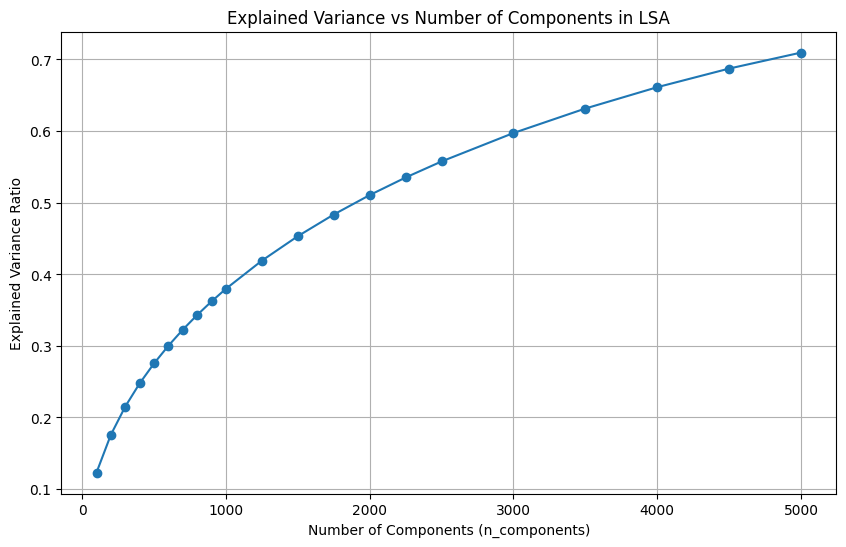

In [28]:
# Plot explained variance vs n_components
plt.figure(figsize=(10, 6))
plt.plot(df_variance["n_components"], df_variance["explained_variance"], marker='o')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components in LSA')
plt.grid(True)
plt.show()

## Final TruncatedSVD

Reduce from 30K dimensions to N_COMPONENTS latent components (LSA). This will reduce noise and make clustering faster and more stable.

In [33]:
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_SEED)
svd

,n_components,500
,algorithm,'randomized'
,n_iter,5
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,31415
,tol,0.0


In [34]:
# Noramailzer helps to make distances for K-means more stable
normalizer = Normalizer(copy=False)
normalizer

,norm,'l2'
,copy,False


In [35]:
# Create a pipeline that first applies SVD and then normalizes the result
svd_pipeline = make_pipeline(svd, normalizer)
svd_pipeline

,steps,"[('truncatedsvd', ...), ('normalizer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,500
,algorithm,'randomized'
,n_iter,5
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,31415
,tol,0.0


In [36]:
# Fit and transform the TF-IDF matrix to obtain the reduced representation
X_reduced = svd_pipeline.fit_transform(X_tfidf)
X_reduced.shape

(89928, 500)

In [37]:
explained_var = svd.explained_variance_ratio_.sum()
explained_var

np.float64(0.27326478308297975)

# Clustering with K-Means

In [18]:
"""
Now we can cluster the news articles in this reduced 100-dimensional space using K-means clustering.
"""

'\nNow we can cluster the news articles in this reduced 100-dimensional space using K-means clustering.\n'

In [19]:
def evaluate_k(k_values, X):
	"""
	Trains K-means for each k in k_values and computes the silhouette score.
	Args:
		k_values (list): List of k values to evaluate.
		X (array-like): Data to cluster.
	Returns:
		results (list): List of dicts with k and silhouette score.
	"""
	results = []
	for k in k_values:
		km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init="auto")
		labels = km.fit_predict(X)
		sil = silhouette_score(X, labels)
		inertia = km.inertia_
		results.append({"k": k, "silhouette": sil, "inertia": inertia})
		print(f"k={k}, silhouette={sil:.4f}, inertia={inertia:.4f}")
	return results

In [20]:
results = evaluate_k([10, 15, 20, 30, 40, 50], X_reduced)
df_results = pd.DataFrame(results)
df_results

NameError: name 'X_reduced' is not defined

In [47]:
results_2 = evaluate_k([60, 70, 80, 90, 100], X_reduced)
df_results_2 = pd.DataFrame(results_2)
df_results = pd.concat([df_results, df_results_2], ignore_index=True)
df_results

k=60, silhouette=0.0490, inertia=69654.5647
k=70, silhouette=0.0542, inertia=68346.7481
k=80, silhouette=0.0593, inertia=67241.3586
k=90, silhouette=0.0633, inertia=66155.8960
k=100, silhouette=0.0653, inertia=65313.7508


,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790
6,60,0.049041,69654.564674
7,70,0.054201,68346.748120
8,80,0.059268,67241.358622
9,90,0.063287,66155.895973


In [50]:
results_3 = evaluate_k([150, 200, 250, 300, 400, 500], X_reduced)
df_results_3 = pd.DataFrame(results_3)
df_results = pd.concat([df_results, df_results_3], ignore_index=True)
df_results

k=150, silhouette=0.0787, inertia=61070.3059
k=200, silhouette=0.0895, inertia=57725.9122
k=250, silhouette=0.0983, inertia=55086.2610
k=300, silhouette=0.1042, inertia=53044.2931
k=400, silhouette=0.1060, inertia=50268.0333
k=500, silhouette=0.1035, inertia=48270.5746


,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790
6,60,0.049041,69654.564674
7,70,0.054201,68346.748120
8,80,0.059268,67241.358622
9,90,0.063287,66155.895973


In [52]:
results_4 = evaluate_k([325, 350, 375, 425, 450, 475], X_reduced)
df_results_4 = pd.DataFrame(results_4)
df_results = pd.concat([df_results, df_results_4], ignore_index=True)
df_results = df_results.sort_values(by="k", ascending=True)
df_results

k=325, silhouette=0.1044, inertia=52301.4346
k=350, silhouette=0.1057, inertia=51545.9716
k=375, silhouette=0.1060, inertia=50843.5771
k=425, silhouette=0.1080, inertia=49547.2217
k=450, silhouette=0.1055, inertia=49157.9553
k=475, silhouette=0.1047, inertia=48733.8044


,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790
6,60,0.049041,69654.564674
7,70,0.054201,68346.748120
8,80,0.059268,67241.358622
9,90,0.063287,66155.895973


In [54]:
results_5 = evaluate_k([280, 285, 290, 295, 305, 310, 315, 320], X_reduced)
df_results_5 = pd.DataFrame(results_5)
df_results = pd.concat([df_results, df_results_5], ignore_index=True)
df_results = df_results.sort_values(by="k", ascending=True)
df_results

k=280, silhouette=0.1006, inertia=53947.5267
k=285, silhouette=0.1016, inertia=53661.5502
k=290, silhouette=0.1020, inertia=53491.4930
k=295, silhouette=0.1027, inertia=53288.7411
k=305, silhouette=0.1038, inertia=52980.0261
k=310, silhouette=0.1046, inertia=52755.7425
k=315, silhouette=0.1052, inertia=52542.6682
k=320, silhouette=0.1045, inertia=52464.6343


,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790
6,60,0.049041,69654.564674
7,70,0.054201,68346.748120
8,80,0.059268,67241.358622
9,90,0.063287,66155.895973


In [56]:
results_6 = evaluate_k([275], X_reduced)
df_results_6 = pd.DataFrame(results_6)
df_results = pd.concat([df_results, df_results_6], ignore_index=True)
df_results = df_results.sort_values(by="k", ascending=True)
df_results

k=275, silhouette=0.1013, inertia=54036.6844


,k,silhouette,inertia
0,10,0.015574,79773.701419
1,15,0.023573,77927.273807
2,20,0.025467,76681.391512
3,30,0.034426,74188.208965
4,40,0.039640,72395.908199
5,50,0.045211,71035.164790
6,60,0.049041,69654.564674
7,70,0.054201,68346.748120
8,80,0.059268,67241.358622
9,90,0.063287,66155.895973


In [59]:
df_results_copy = df_results.copy()
df_results.drop(index=[14,15,16,17,19,20,21,22], inplace=True)

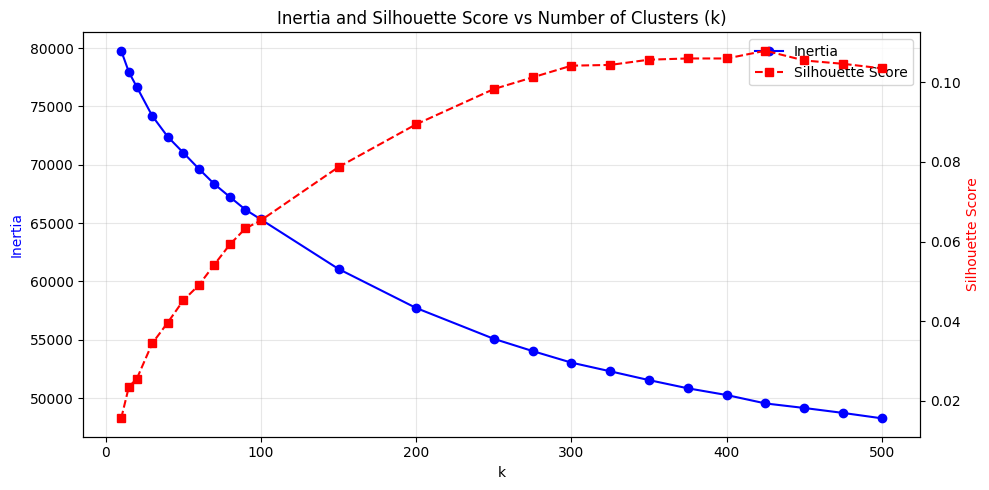

In [60]:
# Plot inertia and silhouette score vs number of clusters (k) with two y-axes
import matplotlib.pyplot as plt

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 5))

# First axis Y (left)
ax1.plot(df_results["k"], df_results["inertia"], marker="o", color="b", label="Inertia")
ax1.set_xlabel("k")
ax1.set_ylabel("Inertia", color="b")
ax1.grid(True, alpha=0.3)

# Second axis Y (right)
ax2 = ax1.twinx()
ax2.plot(df_results["k"], df_results["silhouette"], marker="s", linestyle="--", color="r", label="Silhouette Score")
ax2.set_ylabel("Silhouette Score", color="r")

# Combined legend (from both axes)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("Inertia and Silhouette Score vs Number of Clusters (k)")
plt.tight_layout()
plt.show()

In [61]:
"""
The silhouette score reaches an elbow around k=300, which suggests that increasing k further yields diminishing returns in cluster quality.
"""
selected_k = 300

In [62]:
# Train final K-means model with the selected number of clusters
kmeans = KMeans(n_clusters=selected_k, random_state=RANDOM_SEED, n_init="auto")
cluster_labels = kmeans.fit_predict(X_reduced)

df_train["topic_id"] = cluster_labels
df_train[["news_id", "topic_id"]]

KeyError: "['news_id'] not in index"

# Gridsearch for hyperparameters tuning

In [ ]:
# Define the pipeline for topic modeling
topics_pipeline = Pipeline([
	("tfidf", TfidfVectorizer(min_df=5, max_df=0.7, ngram_range=(1,2), dtype=np.float32)),
	("svd", TruncatedSVD(random_state=RANDOM_SEED)),
	("cluster", MiniBatchKMeans(
        random_state=RANDOM_SEED,
        n_init=1,
        max_iter=100,
        batch_size=2048,
	))
])

In [20]:
param_grid = {
	"tfidf__max_features": [30_000, 75_000, 125_000],
	# "tfidf__min_df": [3, 5, 10],
	# "tfidf__max_df": [0.7, 0.8, 0.9],
	"svd__n_components": [1_250, 2_500, 5_000],
	"cluster__n_clusters": [200, 300, 425],
}

In [23]:
# from sklearn.metrics import silhouette_score

# def silhouette_scorer(estimator, X, y=None):
# 	"""
# 	Compute silhouette score on the SVD space using KMeans labels.
# 	Assumes estimator is a Pipeline: [tfidf -> svd -> cluster].
# 	"""
# 	# Transform text into reduced space
# 	X_svd = estimator[:-1].transform(X)
# 	# Get cluster labels from last step (KMeans)
# 	labels = estimator[-1].labels_
	
# 	# For seguridad: si todos los puntos caen en el mismo cluster,
# 	# silhouette no está definido -> devolvemos algo muy malo.
# 	if len(set(labels)) < 2:
# 		return -1.0
	
# 	return silhouette_score(X_svd, labels)

In [53]:
def calculate_df_silhouettes_from_gridsearch(
	texts: list,
	param_grid: dict,
	n_run: int = 0,
	random_seed: int = RANDOM_SEED
) -> pd.DataFrame:
	"""
	Perform GridSearchCV to find best hyperparameters for topic modeling pipeline
	using silhouette score as evaluation metric.
	Args:
		texts (list): List of text documents.
		param_grid (dict): Hyperparameter grid for GridSearchCV.
		random_seed (int): Random seed for reproducibility.
	Returns:
		pd.DataFrame: DataFrame with silhouette scores for each hyperparameter combination.
	"""
	
	def _silhouette_scorer(estimator, X, y=None):
		# Transform X (tfidf + svd)
		X_emb = estimator[:-1].transform(X)

		# Predict cluster labels on this X
		labels = estimator.named_steps["cluster"].predict(X_emb)

		# Compute silhouette on a smaller sample to speed up
		return silhouette_score(
			X_emb,
			labels,
			metric="euclidean",
			sample_size=min(5000, X_emb.shape[0]),
			random_state=RANDOM_SEED,
		)

	texts = np.asarray(texts, dtype=object)  # assumes you already have `texts`

	SUBSAMPLE_N = min(30000, len(texts))     # adjust if you want
	rng = np.random.default_rng(random_seed)
	idx = rng.choice(len(texts), size=SUBSAMPLE_N, replace=False)
	texts_sub = texts[idx]

	single_split = [(np.arange(len(texts_sub)), np.arange(len(texts_sub)))]

	estimator = Pipeline([
		("tfidf", TfidfVectorizer(
			max_features=30_000,
			min_df=5,
			max_df=0.7,
			ngram_range=(1,2),
			dtype=np.float32,
		)),
		("svd", TruncatedSVD(
			n_components=20,
			random_state=random_seed
		)),
		("cluster", MiniBatchKMeans(
			n_clusters=30,
			n_init=1,
			max_iter=100,
			batch_size=2048,
			random_state=random_seed,
		))
	])

	grid_search = GridSearchCV(
		estimator=estimator,
		param_grid=param_grid,
		scoring=_silhouette_scorer,
		cv=single_split,              # single evaluation split
		n_jobs=-1,
		verbose=2,
		refit=True,
	)
	grid_search.fit(texts_sub)

	print("Best silhouette score:", grid_search.best_score_)
	print("Best params:")
	for k, v in grid_search.best_params_.items():
		print(f"  {k}: {v}")

	df_silhouettes = pd.DataFrame(grid_search.cv_results_)
	df_silhouettes = df_silhouettes.sort_values(by="mean_test_score", ascending=False)
	df_silhouettes.to_csv(f"df_silhouettes_{n_run}.csv", index=False)

	return df_silhouettes

In [21]:
def silhouette_scorer(estimator, X, y=None):
    # Transform X (tfidf + svd)
    X_emb = estimator[:-1].transform(X)

    # Predict cluster labels on this X
    labels = estimator.named_steps["cluster"].predict(X_emb)

    # Compute silhouette on a smaller sample to speed up
    return silhouette_score(
        X_emb,
        labels,
        metric="euclidean",
        sample_size=min(5000, X_emb.shape[0]),
        random_state=RANDOM_SEED,
    )

In [22]:
texts = np.asarray(texts, dtype=object)  # assumes you already have `texts`

SUBSAMPLE_N = min(30000, len(texts))     # adjust if you want
rng = np.random.default_rng(RANDOM_SEED)
idx = rng.choice(len(texts), size=SUBSAMPLE_N, replace=False)
texts_sub = texts[idx]

In [23]:
single_split = [(np.arange(len(texts_sub)), np.arange(len(texts_sub)))]

In [24]:
grid_search = GridSearchCV(
    estimator=topics_pipeline,
    param_grid=param_grid,
    scoring=silhouette_scorer,
    cv=single_split,              # single evaluation split
    n_jobs=-1,
    verbose=2,
    refit=True,
)
grid_search.fit(texts_sub)

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV] END cluster__n_clusters=200, svd__n_components=1250, tfidf__max_features=30000; total time= 2.2min
[CV] END cluster__n_clusters=200, svd__n_components=1250, tfidf__max_features=75000; total time= 2.8min
[CV] END cluster__n_clusters=200, svd__n_components=1250, tfidf__max_features=125000; total time= 3.0min
[CV] END cluster__n_clusters=200, svd__n_components=2500, tfidf__max_features=30000; total time= 4.1min
[CV] END cluster__n_clusters=200, svd__n_components=2500, tfidf__max_features=75000; total time= 5.1min
[CV] END cluster__n_clusters=200, svd__n_components=2500, tfidf__max_features=125000; total time= 6.4min
[CV] END cluster__n_clusters=300, svd__n_components=1250, tfidf__max_features=30000; total time= 2.2min
[CV] END cluster__n_clusters=200, svd__n_components=5000, tfidf__max_features=30000; total time= 9.8min
[CV] END cluster__n_clusters=300, svd__n_components=1250, tfidf__max_features=75000; total time= 2.7min
[

,estimator,Pipeline(step...tate=31415))])
,param_grid,"{'cluster__n_clusters': [200, 300, ...], 'svd__n_components': [1250, 2500, ...], 'tfidf__max_features': [30000, 75000, ...]}"
,scoring,<function sil...x7f3e39582170>
,n_jobs,-1
,refit,True
,cv,"[(array([ 0,...hape=(30000,)), ...)]"
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [25]:
print("Best silhouette score:", grid_search.best_score_)
print("Best params:")
for k, v in grid_search.best_params_.items():
	print(f"  {k}: {v}")

Best silhouette score: -0.021485907956957817
Best params:
  cluster__n_clusters: 300
  svd__n_components: 5000
  tfidf__max_features: 30000


In [ ]:
df_silhouettes = pd.DataFrame(grid_search.cv_results_)
df_silhouettes = df_silhouettes.sort_values(by="mean_test_score", ascending=False)
df_silhouettes.to_parquet("gridsearch_topics_results.parquet", index=False)

In [28]:
df_silhouettes

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cluster__n_clusters,param_svd__n_components,param_tfidf__max_features,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
15,565.353293,0.0,33.676426,0.0,300,5000,30000,"{'cluster__n_clusters': 300, 'svd__n_component...",-0.021486,-0.021486,0.0,1
6,550.437312,0.0,34.919725,0.0,200,5000,30000,"{'cluster__n_clusters': 200, 'svd__n_component...",-0.025949,-0.025949,0.0,2
17,946.569178,0.0,44.890906,0.0,300,5000,125000,"{'cluster__n_clusters': 300, 'svd__n_component...",-0.033847,-0.033847,0.0,3
16,757.975217,0.0,42.638672,0.0,300,5000,75000,"{'cluster__n_clusters': 300, 'svd__n_component...",-0.036109,-0.036109,0.0,4
24,578.432538,0.0,38.615705,0.0,425,5000,30000,"{'cluster__n_clusters': 425, 'svd__n_component...",-0.037035,-0.037035,0.0,5
7,728.339469,0.0,42.402227,0.0,200,5000,75000,"{'cluster__n_clusters': 200, 'svd__n_component...",-0.037348,-0.037348,0.0,6
0,115.292088,0.0,18.534763,0.0,200,1250,30000,"{'cluster__n_clusters': 200, 'svd__n_component...",-0.049406,-0.049406,0.0,7
9,115.352608,0.0,15.842765,0.0,300,1250,30000,"{'cluster__n_clusters': 300, 'svd__n_component...",-0.051861,-0.051861,0.0,8
2,160.185774,0.0,21.506955,0.0,200,1250,125000,"{'cluster__n_clusters': 200, 'svd__n_component...",-0.059067,-0.059067,0.0,9
26,907.072502,0.0,40.234002,0.0,425,5000,125000,"{'cluster__n_clusters': 425, 'svd__n_component...",-0.064042,-0.064042,0.0,10


In [29]:
topics_pipeline_2 = Pipeline([
	("tfidf", TfidfVectorizer(
        min_df=5,
        max_df=0.7,
        ngram_range=(1,2),
        dtype=np.float32,
        max_features=30_000,
	)),
	("svd", TruncatedSVD(random_state=RANDOM_SEED)),
	("cluster", MiniBatchKMeans(
        random_state=RANDOM_SEED,
        n_init=1,
        max_iter=100,
        batch_size=2048,
        n_clusters=300,
	))
])

In [30]:
param_grid_2 = {
	"svd__n_components": [300, 600, 1_000, 1_500, 2_000, 3_000, 4_000, 5_000, 6_000, 8_000],
}

In [31]:
grid_search_2 = GridSearchCV(
    estimator=topics_pipeline_2,
    param_grid=param_grid_2,
    scoring=silhouette_scorer,
    cv=single_split,              # single evaluation split
    n_jobs=-1,
    verbose=2,
    refit=True,
)
grid_search_2.fit(texts_sub)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] END ..............................svd__n_components=300; total time= 1.1min
[CV] END ..............................svd__n_components=600; total time= 1.5min
[CV] END .............................svd__n_components=1000; total time= 1.9min
[CV] END .............................svd__n_components=1500; total time= 2.7min
[CV] END .............................svd__n_components=2000; total time= 3.3min
[CV] END .............................svd__n_components=3000; total time= 5.2min
[CV] END .............................svd__n_components=4000; total time= 7.2min
[CV] END .............................svd__n_components=5000; total time= 9.3min
[CV] END .............................svd__n_components=6000; total time=11.8min
[CV] END .............................svd__n_components=8000; total time=17.8min


,estimator,Pipeline(step...tate=31415))])
,param_grid,"{'svd__n_components': [300, 600, ...]}"
,scoring,<function sil...x7f3e39582170>
,n_jobs,-1
,refit,True
,cv,"[(array([ 0,...hape=(30000,)), ...)]"
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [32]:
print("Best silhouette score:", grid_search_2.best_score_)
print("Best params:")
for k, v in grid_search_2.best_params_.items():
	print(f"  {k}: {v}")

Best silhouette score: 0.05514812469482422
Best params:
  svd__n_components: 300


In [33]:
df_silhouettes_2 = pd.DataFrame(grid_search_2.cv_results_)
df_silhouettes_2 = df_silhouettes_2.sort_values(by="mean_test_score", ascending=False)
df_silhouettes_2.to_parquet("gridsearch_topics_results_2.parquet", index=False)
df_silhouettes_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svd__n_components,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,48.648275,0.0,15.117671,0.0,300,{'svd__n_components': 300},0.055148,0.055148,0.0,1
1,71.371637,0.0,16.060279,0.0,600,{'svd__n_components': 600},0.005716,0.005716,0.0,2
9,1026.051162,0.0,41.947782,0.0,8000,{'svd__n_components': 8000},-0.016724,-0.016724,0.0,3
7,529.308955,0.0,30.657528,0.0,5000,{'svd__n_components': 5000},-0.021486,-0.021486,0.0,4
8,670.725806,0.0,38.115945,0.0,6000,{'svd__n_components': 6000},-0.024459,-0.024459,0.0,5
6,403.344088,0.0,28.740526,0.0,4000,{'svd__n_components': 4000},-0.038235,-0.038235,0.0,6
3,140.638172,0.0,19.544721,0.0,1500,{'svd__n_components': 1500},-0.053545,-0.053545,0.0,7
4,177.094762,0.0,18.949740,0.0,2000,{'svd__n_components': 2000},-0.053915,-0.053915,0.0,8
5,283.585524,0.0,25.419045,0.0,3000,{'svd__n_components': 3000},-0.056105,-0.056105,0.0,9
2,99.363111,0.0,16.808532,0.0,1000,{'svd__n_components': 1000},-0.056111,-0.056111,0.0,10


In [ ]:
topics_pipeline_3 = Pipeline([
	("tfidf", TfidfVectorizer(
        min_df=5,
        max_df=0.7,
        ngram_range=(1,2),
        dtype=np.float32,
        max_features=30_000,
	)),
	("svd", TruncatedSVD(random_state=RANDOM_SEED)),
	("cluster", MiniBatchKMeans(
        random_state=RANDOM_SEED,
        n_init=1,
        max_iter=100,
        batch_size=2048,
        n_clusters=300,
	))
])


param_grid_3 = {
	"svd__n_components": [50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 800, 900],
}


grid_search_3 = GridSearchCV(
    estimator=topics_pipeline_3,
    param_grid=param_grid_3,
    scoring=silhouette_scorer,
    cv=single_split,              # single evaluation split
    n_jobs=-1,
    verbose=2,
    refit=True,
)
grid_search_3.fit(texts_sub)


print("Best silhouette score:", grid_search_3.best_score_)
print("Best params:")
for k, v in grid_search_3.best_params_.items():
	print(f"  {k}: {v}")


df_silhouettes_3 = pd.DataFrame(grid_search_3.cv_results_)
df_silhouettes_3 = df_silhouettes_3.sort_values(by="mean_test_score", ascending=False)
df_silhouettes_3.to_csv("df_silhouettes_3.csv", index=False)
df_silhouettes_3

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ...............................svd__n_components=50; total time=  41.1s
[CV] END ..............................svd__n_components=100; total time=  44.8s
[CV] END ..............................svd__n_components=150; total time=  47.4s
[CV] END ..............................svd__n_components=200; total time=  50.6s
[CV] END ..............................svd__n_components=250; total time=  52.3s
[CV] END ..............................svd__n_components=300; total time=  54.1s
[CV] END ..............................svd__n_components=350; total time=  59.6s
[CV] END ..............................svd__n_components=400; total time= 1.1min
[CV] END ..............................svd__n_components=500; total time= 1.2min
[CV] END ..............................svd__n_components=600; total time= 1.3min
[CV] END ..............................svd__n_components=800; total time= 1.6min
[CV] END ..............................svd__n_co

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svd__n_components,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,28.021514,0.0,13.098594,0.0,50,{'svd__n_components': 50},0.057336,0.057336,0.0,1
1,32.008440,0.0,12.748976,0.0,100,{'svd__n_components': 100},0.057269,0.057269,0.0,2
5,41.278055,0.0,12.822380,0.0,300,{'svd__n_components': 300},0.055148,0.055148,0.0,3
8,56.548406,0.0,15.925969,0.0,500,{'svd__n_components': 500},0.053485,0.053485,0.0,4
3,37.786877,0.0,12.782650,0.0,200,{'svd__n_components': 200},0.052276,0.052276,0.0,5
2,35.185531,0.0,12.204383,0.0,150,{'svd__n_components': 150},0.048654,0.048654,0.0,6
4,39.293834,0.0,12.977810,0.0,250,{'svd__n_components': 250},0.041873,0.041873,0.0,7
6,46.719614,0.0,12.845823,0.0,350,{'svd__n_components': 350},0.033420,0.033420,0.0,8
9,63.110155,0.0,14.857467,0.0,600,{'svd__n_components': 600},0.005716,0.005716,0.0,9
7,51.941117,0.0,12.615089,0.0,400,{'svd__n_components': 400},-0.003744,-0.003744,0.0,10


In [38]:
topics_pipeline_4 = Pipeline([
	("tfidf", TfidfVectorizer(
        min_df=5,
        max_df=0.7,
        ngram_range=(1,2),
        dtype=np.float32,
        max_features=30_000,
	)),
	("svd", TruncatedSVD(
		random_state=RANDOM_SEED,
		n_components=50,
	)),
	("cluster", MiniBatchKMeans(
        random_state=RANDOM_SEED,
        n_init=1,
        max_iter=100,
        batch_size=2048,
        n_clusters=300,
	))
])


param_grid_4 = {
	"cluster__n_clusters": [30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500],
}


grid_search_4 = GridSearchCV(
    estimator=topics_pipeline_4,
    param_grid=param_grid_4,
    scoring=silhouette_scorer,
    cv=single_split,              # single evaluation split
    n_jobs=-1,
    verbose=2,
    refit=True,
)
grid_search_4.fit(texts_sub)


print("Best silhouette score:", grid_search_4.best_score_)
print("Best params:")
for k, v in grid_search_4.best_params_.items():
	print(f"  {k}: {v}")


df_silhouettes_4 = pd.DataFrame(grid_search_4.cv_results_)
df_silhouettes_4 = df_silhouettes_4.sort_values(by="mean_test_score", ascending=False)
df_silhouettes_4.to_csv("df_silhouettes_4.csv", index=False)
df_silhouettes_4

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ............................cluster__n_clusters=100; total time=  37.6s
[CV] END .............................cluster__n_clusters=30; total time=  38.5s
[CV] END .............................cluster__n_clusters=75; total time=  38.3s
[CV] END .............................cluster__n_clusters=50; total time=  38.6s
[CV] END ............................cluster__n_clusters=150; total time=  38.5s
[CV] END ............................cluster__n_clusters=200; total time=  38.6s
[CV] END ............................cluster__n_clusters=300; total time=  38.9s
[CV] END ............................cluster__n_clusters=250; total time=  39.1s
[CV] END ............................cluster__n_clusters=400; total time=  38.4s
[CV] END ............................cluster__n_clusters=350; total time=  39.0s
[CV] END ............................cluster__n_clusters=450; total time=  38.4s
[CV] END ............................cluster__n_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cluster__n_clusters,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,26.818318,0.0,11.718333,0.0,30,{'cluster__n_clusters': 30},0.077346,0.077346,0.0,1
2,26.712945,0.0,11.584131,0.0,75,{'cluster__n_clusters': 75},0.075293,0.075293,0.0,2
1,26.856574,0.0,11.739000,0.0,50,{'cluster__n_clusters': 50},0.070822,0.070822,0.0,3
3,25.890024,0.0,11.711823,0.0,100,{'cluster__n_clusters': 100},0.067098,0.067098,0.0,4
4,26.290760,0.0,12.196865,0.0,150,{'cluster__n_clusters': 150},0.062575,0.062575,0.0,5
6,26.859171,0.0,12.231014,0.0,250,{'cluster__n_clusters': 250},0.061625,0.061625,0.0,6
5,26.437091,0.0,12.130019,0.0,200,{'cluster__n_clusters': 200},0.061442,0.061442,0.0,7
7,26.652192,0.0,12.205373,0.0,300,{'cluster__n_clusters': 300},0.057336,0.057336,0.0,8
8,26.636811,0.0,12.364591,0.0,350,{'cluster__n_clusters': 350},0.053403,0.053403,0.0,9
9,26.363087,0.0,12.031539,0.0,400,{'cluster__n_clusters': 400},0.049294,0.049294,0.0,10


In [39]:
topics_pipeline_5 = Pipeline([
	("tfidf", TfidfVectorizer(
        min_df=5,
        max_df=0.7,
        ngram_range=(1,2),
        dtype=np.float32,
        max_features=30_000,
	)),
	("svd", TruncatedSVD(
		random_state=RANDOM_SEED,
	)),
	("cluster", MiniBatchKMeans(
        random_state=RANDOM_SEED,
        n_init=1,
        max_iter=100,
        batch_size=2048,
	))
])


param_grid_5 = {
	"svd__n_components": [25, 50, 75, 100],
	"cluster__n_clusters": [25, 50, 75, 100],
}


grid_search_5 = GridSearchCV(
    estimator=topics_pipeline_5,
    param_grid=param_grid_5,
    scoring=silhouette_scorer,
    cv=single_split,              # single evaluation split
    n_jobs=-1,
    verbose=2,
    refit=True,
)
grid_search_5.fit(texts_sub)


print("Best silhouette score:", grid_search_5.best_score_)
print("Best params:")
for k, v in grid_search_5.best_params_.items():
	print(f"  {k}: {v}")


df_silhouettes_5 = pd.DataFrame(grid_search_5.cv_results_)
df_silhouettes_5 = df_silhouettes_5.sort_values(by="mean_test_score", ascending=False)
df_silhouettes_5.to_csv("df_silhouettes_5.csv", index=False)
df_silhouettes_5

Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV] END .......cluster__n_clusters=25, svd__n_components=25; total time=  36.9s
[CV] END .......cluster__n_clusters=25, svd__n_components=50; total time=  37.4s
[CV] END .......cluster__n_clusters=25, svd__n_components=75; total time=  39.2s
[CV] END ......cluster__n_clusters=25, svd__n_components=100; total time=  40.2s
[CV] END .......cluster__n_clusters=50, svd__n_components=25; total time=  37.4s
[CV] END .......cluster__n_clusters=50, svd__n_components=50; total time=  37.8s
[CV] END .......cluster__n_clusters=50, svd__n_components=75; total time=  39.7s
[CV] END ......cluster__n_clusters=50, svd__n_components=100; total time=  41.1s
[CV] END .......cluster__n_clusters=75, svd__n_components=25; total time=  38.2s
[CV] END .......cluster__n_clusters=75, svd__n_components=50; total time=  37.8s
[CV] END .......cluster__n_clusters=75, svd__n_components=75; total time=  39.9s
[CV] END ......cluster__n_clusters=75, svd__n_co

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cluster__n_clusters,param_svd__n_components,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,25.400702,0.0,11.539840,0.0,25,25,"{'cluster__n_clusters': 25, 'svd__n_components...",0.121770,0.121770,0.0,1
1,25.636537,0.0,11.809815,0.0,25,50,"{'cluster__n_clusters': 25, 'svd__n_components...",0.110935,0.110935,0.0,2
4,25.297930,0.0,12.104529,0.0,50,25,"{'cluster__n_clusters': 50, 'svd__n_components...",0.092377,0.092377,0.0,3
8,25.612396,0.0,12.609303,0.0,75,25,"{'cluster__n_clusters': 75, 'svd__n_components...",0.078459,0.078459,0.0,4
12,25.913512,0.0,12.930628,0.0,100,25,"{'cluster__n_clusters': 100, 'svd__n_component...",0.075700,0.075700,0.0,5
9,25.793572,0.0,12.010454,0.0,75,50,"{'cluster__n_clusters': 75, 'svd__n_components...",0.075293,0.075293,0.0,6
5,26.100354,0.0,11.673414,0.0,50,50,"{'cluster__n_clusters': 50, 'svd__n_components...",0.070822,0.070822,0.0,7
13,26.584367,0.0,12.588817,0.0,100,50,"{'cluster__n_clusters': 100, 'svd__n_component...",0.067098,0.067098,0.0,8
14,28.249175,0.0,11.594002,0.0,100,75,"{'cluster__n_clusters': 100, 'svd__n_component...",0.062927,0.062927,0.0,9
10,27.384634,0.0,12.491881,0.0,75,75,"{'cluster__n_clusters': 75, 'svd__n_components...",0.061649,0.061649,0.0,10


In [40]:
topics_pipeline_6 = Pipeline([
	("tfidf", TfidfVectorizer(
        min_df=5,
        max_df=0.7,
        ngram_range=(1,2),
        dtype=np.float32,
        max_features=30_000,
	)),
	("svd", TruncatedSVD(
		random_state=RANDOM_SEED,
	)),
	("cluster", MiniBatchKMeans(
        random_state=RANDOM_SEED,
        n_init=1,
        max_iter=100,
        batch_size=2048,
	))
])


param_grid_6 = {
	"svd__n_components": [5, 10, 15, 20],
	"cluster__n_clusters": [5, 10, 15, 20],
}


grid_search_6 = GridSearchCV(
    estimator=topics_pipeline_6,
    param_grid=param_grid_6,
    scoring=silhouette_scorer,
    cv=single_split,              # single evaluation split
    n_jobs=-1,
    verbose=2,
    refit=True,
)
grid_search_6.fit(texts_sub)


print("Best silhouette score:", grid_search_6.best_score_)
print("Best params:")
for k, v in grid_search_6.best_params_.items():
	print(f"  {k}: {v}")


df_silhouettes_6 = pd.DataFrame(grid_search_6.cv_results_)
df_silhouettes_6 = df_silhouettes_6.sort_values(by="mean_test_score", ascending=False)
df_silhouettes_6.to_csv("df_silhouettes_6.csv", index=False)
df_silhouettes_6

Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV] END ........cluster__n_clusters=5, svd__n_components=10; total time=  36.1s
[CV] END .........cluster__n_clusters=5, svd__n_components=5; total time=  36.4s
[CV] END ........cluster__n_clusters=5, svd__n_components=15; total time=  37.0s
[CV] END ........cluster__n_clusters=5, svd__n_components=20; total time=  36.9s
[CV] END ........cluster__n_clusters=10, svd__n_components=5; total time=  36.2s
[CV] END .......cluster__n_clusters=10, svd__n_components=10; total time=  36.1s
[CV] END .......cluster__n_clusters=10, svd__n_components=20; total time=  36.0s
[CV] END .......cluster__n_clusters=10, svd__n_components=15; total time=  36.4s
[CV] END ........cluster__n_clusters=15, svd__n_components=5; total time=  35.5s
[CV] END .......cluster__n_clusters=15, svd__n_components=10; total time=  36.3s
[CV] END .......cluster__n_clusters=15, svd__n_components=15; total time=  36.0s
[CV] END .......cluster__n_clusters=15, svd__n_c

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cluster__n_clusters,param_svd__n_components,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
4,24.556465,0.0,11.647702,0.0,10,5,"{'cluster__n_clusters': 10, 'svd__n_components...",0.229159,0.229159,0.0,1
1,24.512145,0.0,11.543127,0.0,5,10,"{'cluster__n_clusters': 5, 'svd__n_components'...",0.208328,0.208328,0.0,2
8,24.534349,0.0,11.009264,0.0,15,5,"{'cluster__n_clusters': 15, 'svd__n_components...",0.205690,0.205690,0.0,3
12,24.605146,0.0,12.311002,0.0,20,5,"{'cluster__n_clusters': 20, 'svd__n_components...",0.192820,0.192820,0.0,4
2,25.267734,0.0,11.698665,0.0,5,15,"{'cluster__n_clusters': 5, 'svd__n_components'...",0.181946,0.181946,0.0,5
0,24.826113,0.0,11.589423,0.0,5,5,"{'cluster__n_clusters': 5, 'svd__n_components'...",0.171649,0.171649,0.0,6
13,24.404634,0.0,12.080438,0.0,20,10,"{'cluster__n_clusters': 20, 'svd__n_components...",0.139944,0.139944,0.0,7
5,24.495586,0.0,11.591763,0.0,10,10,"{'cluster__n_clusters': 10, 'svd__n_components...",0.130880,0.130880,0.0,8
9,24.621271,0.0,11.690494,0.0,15,10,"{'cluster__n_clusters': 15, 'svd__n_components...",0.129647,0.129647,0.0,9
3,25.193560,0.0,11.715390,0.0,5,20,"{'cluster__n_clusters': 5, 'svd__n_components'...",0.115767,0.115767,0.0,10


In [41]:
topics_pipeline_7 = Pipeline([
	("tfidf", TfidfVectorizer(
        min_df=5,
        max_df=0.7,
        ngram_range=(1,2),
        dtype=np.float32,
        max_features=30_000,
	)),
	("svd", TruncatedSVD(
		random_state=RANDOM_SEED,
		n_components=20,
	)),
	("cluster", MiniBatchKMeans(
        random_state=RANDOM_SEED,
        n_init=1,
        max_iter=100,
        batch_size=2048,
		n_clusters=20,
	))
])


param_grid_7 = {
	"svd__n_components": [5, 10, 15, 20],
	"cluster__n_clusters": [30, 50, 100, 200, 300],
}


grid_search_7 = GridSearchCV(
    estimator=topics_pipeline_7,
    param_grid=param_grid_7,
    scoring=silhouette_scorer,
    cv=single_split,              # single evaluation split
    n_jobs=-1,
    verbose=2,
    refit=True,
)
grid_search_7.fit(texts_sub)


print("Best silhouette score:", grid_search_7.best_score_)
print("Best params:")
for k, v in grid_search_7.best_params_.items():
	print(f"  {k}: {v}")


df_silhouettes_7 = pd.DataFrame(grid_search_7.cv_results_)
df_silhouettes_7 = df_silhouettes_7.sort_values(by="mean_test_score", ascending=False)
df_silhouettes_7.to_csv("df_silhouettes_7.csv", index=False)
df_silhouettes_7

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV] END .......cluster__n_clusters=30, svd__n_components=15; total time=  37.5s
[CV] END ........cluster__n_clusters=30, svd__n_components=5; total time=  38.5s
[CV] END .......cluster__n_clusters=30, svd__n_components=10; total time=  39.3s
[CV] END .......cluster__n_clusters=30, svd__n_components=20; total time=  39.6s
[CV] END .......cluster__n_clusters=50, svd__n_components=10; total time=  36.0s
[CV] END ........cluster__n_clusters=50, svd__n_components=5; total time=  36.6s
[CV] END .......cluster__n_clusters=50, svd__n_components=20; total time=  36.1s
[CV] END .......cluster__n_clusters=50, svd__n_components=15; total time=  36.9s
[CV] END .......cluster__n_clusters=100, svd__n_components=5; total time=  35.7s
[CV] END ......cluster__n_clusters=100, svd__n_components=10; total time=  35.5s
[CV] END ......cluster__n_clusters=100, svd__n_components=15; total time=  36.0s
[CV] END ......cluster__n_clusters=100, svd__n_c

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cluster__n_clusters,param_svd__n_components,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,26.746418,0.0,11.709774,0.0,30,5,"{'cluster__n_clusters': 30, 'svd__n_components...",0.183815,0.183815,0.0,1
4,24.924469,0.0,11.651354,0.0,50,5,"{'cluster__n_clusters': 50, 'svd__n_components...",0.162744,0.162744,0.0,2
8,24.268489,0.0,11.384587,0.0,100,5,"{'cluster__n_clusters': 100, 'svd__n_component...",0.153893,0.153893,0.0,3
12,24.415607,0.0,11.198606,0.0,200,5,"{'cluster__n_clusters': 200, 'svd__n_component...",0.135713,0.135713,0.0,4
2,26.260877,0.0,11.224824,0.0,30,15,"{'cluster__n_clusters': 30, 'svd__n_components...",0.135023,0.135023,0.0,5
1,27.392958,0.0,11.926958,0.0,30,10,"{'cluster__n_clusters': 30, 'svd__n_components...",0.127735,0.127735,0.0,6
16,26.622262,0.0,12.847140,0.0,300,5,"{'cluster__n_clusters': 300, 'svd__n_component...",0.127064,0.127064,0.0,7
5,24.622647,0.0,11.397260,0.0,50,10,"{'cluster__n_clusters': 50, 'svd__n_components...",0.123149,0.123149,0.0,8
3,27.546305,0.0,12.089125,0.0,30,20,"{'cluster__n_clusters': 30, 'svd__n_components...",0.110746,0.110746,0.0,9
6,25.172313,0.0,11.690273,0.0,50,15,"{'cluster__n_clusters': 50, 'svd__n_components...",0.108013,0.108013,0.0,10


In [54]:
df_silhouettes_dicts = {}

In [55]:
n_run = 8
param_grid = {
	"svd__n_components": [5, 10, 15],
	"cluster__n_clusters": [30, 50, 100],
	"tfidf__max_features": [10_000, 20_000, 30_000],
}
df_silhouettes_dicts[n_run] = calculate_df_silhouettes_from_gridsearch(texts,	param_grid, n_run=n_run)

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV] END cluster__n_clusters=30, svd__n_components=5, tfidf__max_features=10000; total time=  37.2s
[CV] END cluster__n_clusters=30, svd__n_components=10, tfidf__max_features=10000; total time=  37.1s
[CV] END cluster__n_clusters=30, svd__n_components=5, tfidf__max_features=30000; total time=  37.6s
[CV] END cluster__n_clusters=30, svd__n_components=5, tfidf__max_features=20000; total time=  38.5s
[CV] END cluster__n_clusters=30, svd__n_components=10, tfidf__max_features=20000; total time=  36.5s
[CV] END cluster__n_clusters=30, svd__n_components=15, tfidf__max_features=10000; total time=  36.3s
[CV] END cluster__n_clusters=30, svd__n_components=15, tfidf__max_features=20000; total time=  36.1s
[CV] END cluster__n_clusters=30, svd__n_components=10, tfidf__max_features=30000; total time=  37.2s
[CV] END cluster__n_clusters=50, svd__n_components=5, tfidf__max_features=10000; total time=  35.1s
[CV] END cluster__n_clusters=30, s

In [56]:
df_silhouettes_dicts[8]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cluster__n_clusters,param_svd__n_components,param_tfidf__max_features,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
2,25.413435,0.0,12.153091,0.0,30,5,30000,"{'cluster__n_clusters': 30, 'svd__n_components...",0.183815,0.183815,0.0,1
0,25.690948,0.0,11.546645,0.0,30,5,10000,"{'cluster__n_clusters': 30, 'svd__n_components...",0.178368,0.178368,0.0,2
11,25.168376,0.0,11.637619,0.0,50,5,30000,"{'cluster__n_clusters': 50, 'svd__n_components...",0.162744,0.162744,0.0,3
1,26.004392,0.0,12.530136,0.0,30,5,20000,"{'cluster__n_clusters': 30, 'svd__n_components...",0.161699,0.161699,0.0,4
9,24.140166,0.0,10.934263,0.0,50,5,10000,"{'cluster__n_clusters': 50, 'svd__n_components...",0.161456,0.161456,0.0,5
10,24.725472,0.0,11.602514,0.0,50,5,20000,"{'cluster__n_clusters': 50, 'svd__n_components...",0.155941,0.155941,0.0,6
20,25.107688,0.0,12.321163,0.0,100,5,30000,"{'cluster__n_clusters': 100, 'svd__n_component...",0.153893,0.153893,0.0,7
19,24.677735,0.0,11.469509,0.0,100,5,20000,"{'cluster__n_clusters': 100, 'svd__n_component...",0.150863,0.150863,0.0,8
18,24.579366,0.0,10.820198,0.0,100,5,10000,"{'cluster__n_clusters': 100, 'svd__n_component...",0.148700,0.148700,0.0,9
7,24.953176,0.0,11.113861,0.0,30,15,20000,"{'cluster__n_clusters': 30, 'svd__n_components...",0.142613,0.142613,0.0,10


In [57]:
n_run += 1
param_grid = {
	"svd__n_components": [5],
	"cluster__n_clusters": [30],
	"tfidf__max_features": [30_000],
    "tfidf__min_df": [3, 5, 10],
    "tfidf__max_df": [0.6, 0.7, 0.8],
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
}
df_silhouettes_dicts[n_run] = calculate_df_silhouettes_from_gridsearch(texts,	param_grid, n_run=n_run)
df_silhouettes_dicts[n_run]

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV] END cluster__n_clusters=30, svd__n_components=5, tfidf__max_df=0.6, tfidf__max_features=30000, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=  10.5s
[CV] END cluster__n_clusters=30, svd__n_components=5, tfidf__max_df=0.6, tfidf__max_features=30000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=  10.7s
[CV] END cluster__n_clusters=30, svd__n_components=5, tfidf__max_df=0.6, tfidf__max_features=30000, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=  35.5s
[CV] END cluster__n_clusters=30, svd__n_components=5, tfidf__max_df=0.6, tfidf__max_features=30000, tfidf__min_df=10, tfidf__ngram_range=(1, 1); total time=  10.3s
[CV] END cluster__n_clusters=30, svd__n_components=5, tfidf__max_df=0.6, tfidf__max_features=30000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=  36.2s
[CV] END cluster__n_clusters=30, svd__n_components=5, tfidf__max_df=0.6, tfidf__max_features=30000, tfidf__min_df=10, tfidf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cluster__n_clusters,param_svd__n_components,param_tfidf__max_df,param_tfidf__max_features,param_tfidf__min_df,param_tfidf__ngram_range,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
12,5.946283,0.0,5.319355,0.0,30,5,0.7,30000,5,"(1, 1)","{'cluster__n_clusters': 30, 'svd__n_components...",0.203593,0.203593,0.0,1
21,5.495340,0.0,5.166652,0.0,30,5,0.8,30000,5,"(1, 1)","{'cluster__n_clusters': 30, 'svd__n_components...",0.203593,0.203593,0.0,1
20,65.817327,0.0,17.876948,0.0,30,5,0.8,30000,3,"(1, 3)","{'cluster__n_clusters': 30, 'svd__n_components...",0.194913,0.194913,0.0,3
11,65.635054,0.0,17.700570,0.0,30,5,0.7,30000,3,"(1, 3)","{'cluster__n_clusters': 30, 'svd__n_components...",0.194913,0.194913,0.0,3
1,24.137439,0.0,11.344127,0.0,30,5,0.6,30000,3,"(1, 2)","{'cluster__n_clusters': 30, 'svd__n_components...",0.194617,0.194617,0.0,5
8,65.131948,0.0,18.034144,0.0,30,5,0.6,30000,10,"(1, 3)","{'cluster__n_clusters': 30, 'svd__n_components...",0.188913,0.188913,0.0,6
4,24.399042,0.0,11.846260,0.0,30,5,0.6,30000,5,"(1, 2)","{'cluster__n_clusters': 30, 'svd__n_components...",0.185336,0.185336,0.0,7
22,24.115534,0.0,11.454338,0.0,30,5,0.8,30000,5,"(1, 2)","{'cluster__n_clusters': 30, 'svd__n_components...",0.183815,0.183815,0.0,8
13,24.414204,0.0,11.407230,0.0,30,5,0.7,30000,5,"(1, 2)","{'cluster__n_clusters': 30, 'svd__n_components...",0.183815,0.183815,0.0,8
9,5.414038,0.0,5.141604,0.0,30,5,0.7,30000,3,"(1, 1)","{'cluster__n_clusters': 30, 'svd__n_components...",0.182576,0.182576,0.0,10


## Final model

In [60]:
# Build final pipeline with best hyperparameters found
final_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=TFIDF_BEST_MAX_FEATURES,
		min_df=TFIDF_BEST_MIN_DF,
        max_df=TFIDF_BEST_MAX_DF,
        ngram_range=TFIDF_BEST_NGRAM_RANGE,
        dtype=np.float32,
    )),
    ("svd", TruncatedSVD(
        n_components=SVD_BEST_N_COMPONENTS,
		random_state=RANDOM_SEED,
    )),
    ("cluster", KMeans(
        n_clusters=KMEANS_BEST_N_CLUSTERS,
		n_init=10,
        max_iter=300,
		random_state=RANDOM_SEED,
    )),
])

# Fit the pipeline on the full dataset (includes TF-IDF, SVD, and K-means)
final_pipeline.fit(texts)

# Get the reduced representation of the full dataset (output of SVD)
X_reduced_final = final_pipeline[:-1].transform(texts)

# Get cluster labels
cluster_labels = final_pipeline.named_steps["cluster"].labels_

# Compute silhouette score on the full dataset
final_silhouette = silhouette_score(X_reduced_final, cluster_labels)
print(f"Final silhouette score on full dataset: {final_silhouette:.4f}")

Final silhouette score on full dataset: 0.2065


In [107]:
# Assign cluster labels to the original dataframe
df_train["id_topic"] = cluster_labels
df_train

,id_news,title,content,text,len_text,id_topic
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"Singer, activist Joan Baez becomes Kennedy Cen...",177,4
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'Nothing but problems': Shipwreck tear-down en...,5332,11
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,Report: At least 13 dead in Istanbul bombings....,248,4
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,Senate Republicans Pressure Joe Biden to Withd...,4920,8
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,The Unwelcome Return of the Real Purveyors of ...,3894,25
...,...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,An Interview with Mark Blaxill on the Autism T...,1998,12
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,Vietnam reconsiders methane-emitting rice amid...,9005,14
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,Shaker furniture: Clean by design. The Hancock...,262,4
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",2093,26


# Add distance to centroid metric

In [108]:
# Get centroids
centroids = final_pipeline.named_steps["cluster"].cluster_centers_
centroids.shape  # (n_clusters, n_components)

(30, 5)

In [109]:
# Calculate distances to centroids
distances = LA.norm(X_reduced_final - centroids[cluster_labels], axis=1)
distances.shape

(89928,)

In [110]:
# Add distance to centroid metric to df_train
df_train["dist_centroid"] = distances
df_train

,id_news,title,content,text,len_text,id_topic,dist_centroid
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"Singer, activist Joan Baez becomes Kennedy Cen...",177,4,0.046345
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'Nothing but problems': Shipwreck tear-down en...,5332,11,0.050619
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,Report: At least 13 dead in Istanbul bombings....,248,4,0.052706
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,Senate Republicans Pressure Joe Biden to Withd...,4920,8,0.046275
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,The Unwelcome Return of the Real Purveyors of ...,3894,25,0.067005
...,...,...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,An Interview with Mark Blaxill on the Autism T...,1998,12,0.076289
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,Vietnam reconsiders methane-emitting rice amid...,9005,14,0.058756
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,Shaker furniture: Clean by design. The Hancock...,262,4,0.045652
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",2093,26,0.041276


In [111]:
"""Compute z-score of distance to centroid within each cluster."""

# Compute per-cluster mean and std, then z-score per row
g = df_train.groupby("id_topic")["dist_centroid"]
df_train["dist_mean"] = g.transform("mean")
df_train["dist_std"]  = g.transform("std")  # sample std (ddof=1)

# Avoid division by zero when a cluster has std=0 (all distances identical)
df_train["dist_centroid_z_score"] = np.where(
    df_train["dist_std"] > 0,
    (df_train["dist_centroid"] - df_train["dist_mean"]) / df_train["dist_std"],
    0.0
)

# Remove intermediate columns
df_train.drop(columns=["dist_mean", "dist_std"], inplace=True)

df_train

,id_news,title,content,text,len_text,id_topic,dist_centroid,dist_centroid_z_score
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"Singer, activist Joan Baez becomes Kennedy Cen...",177,4,0.046345,0.625137
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'Nothing but problems': Shipwreck tear-down en...,5332,11,0.050619,-0.686251
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,Report: At least 13 dead in Istanbul bombings....,248,4,0.052706,1.108624
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,Senate Republicans Pressure Joe Biden to Withd...,4920,8,0.046275,-1.235638
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,The Unwelcome Return of the Real Purveyors of ...,3894,25,0.067005,-0.650737
...,...,...,...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,An Interview with Mark Blaxill on the Autism T...,1998,12,0.076289,0.014586
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,Vietnam reconsiders methane-emitting rice amid...,9005,14,0.058756,-0.884641
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,Shaker furniture: Clean by design. The Hancock...,262,4,0.045652,0.572494
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",2093,26,0.041276,-1.020911


# Inspect topics

In [62]:
# Get the vocabulary (feature names) from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()
feature_names

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

In [66]:
def show_cluster_examples(df, id_topic, n=5):
	"""
	Show n example titles from the given cluster_id.
	"""
	subset = df[df["id_topic"] == id_topic].sample(n, random_state=RANDOM_SEED)
	for i, row in subset.iterrows():
		print(f"- {row['title']}")

In [67]:
def top_terms_for_cluster(X_tfidf, labels, id_topic, n_terms=50):
	"""
	Get the top n_terms with highest average TF-IDF score in the given cluster_id.
	Args:
		X_tfidf (sparse matrix): TF-IDF matrix.
		labels (array-like): Cluster labels for each document.
		topic_id (int): Cluster ID to analyze.
		n_terms (int): Number of top terms to return.
	Returns:
		list: Top n_terms feature names for the cluster.
	"""
	idx = np.where(labels == id_topic)[0]
	X_cluster = X_tfidf[idx]
	# suma de tfidf en el cluster
	tfidf_mean = np.asarray(X_cluster.mean(axis=0)).ravel()
	top_idx = tfidf_mean.argsort()[::-1][:n_terms]
	return [feature_names[i] for i in top_idx]

In [68]:
# Display top terms and example titles for some random clusters
random.seed(RANDOM_SEED)
for c in random.sample(range(30), 5):
	print(f"\n=== CLUSTER {c} ===")
	print(top_terms_for_cluster(X_tfidf, cluster_labels, c))
	show_cluster_examples(df_train, c, n=5)


=== CLUSTER 18 ===
['biden', 'president', 'said', 'state', 'administration', 'house', 'trump', 'senate', 'democrats', 'border', 'election', 'federal', 'states', 'law', 'new', 'joe', 'republicans', 'court', 'voting', 'republican', 'joe biden', 'texas', 'biden administration', 'percent', 'vote', 'voters', 'american', 'news', 'immigration', 'white', 'americans', 'government', 'support', 'department', 'rights', 'united', 'legislation', 'democratic', 'white house', 'illegal', 'people', 'breitbart', 'president joe', 'united states', 'act', 'party', 'plan', 'policy', '000', 'secretary']
- Ron DeSantis Notified Of Federal Action Over Discrimination
- State Department: Labeling Houthis Terrorists Blocked Aid to Yemen
- How to fight back against Republican efforts to 'overthrow legitimate election results': columnist
- Israeli PM denounces Iran, ignores Palestinians in UN speech
- Senate Democrats move immediately to "Plan B" on minimum wage

=== CLUSTER 25 ===
['biden', 'democrats', 'president

# Building of topics metadata

In [112]:
# Build a df with a register per topic/cluster
df_topics_meta = (
	df_train
	.groupby("id_topic")
	.agg(size=("id_news", "count"))
	.reset_index()
)

df_topics_meta["top_terms"] = df_topics_meta["id_topic"].apply(
	lambda c: top_terms_for_cluster(X_tfidf, cluster_labels, c, n_terms=N_TOP_TERMS)
)

df_topics_meta

,id_topic,size,top_terms
0,0,732,"[people, just, like, think, going, know, biden..."
1,1,3785,"[said, police, city, year, state, people, cour..."
2,2,1403,"[said, just, like, time, know, people, did, go..."
3,3,1145,"[vaccine, covid, covid 19, 19, vaccinated, vac..."
4,4,14126,"[cbs, new, says, reports, news, cbsn, cbs news..."
5,5,783,"[don, want, people, today, like, feel, make, t..."
6,6,2248,"[covid, vaccine, covid 19, 19, said, health, v..."
7,7,2264,"[trump, president, biden, election, house, don..."
8,8,1912,"[capitol, said, trump, president, cuomo, polic..."
9,9,4063,"[covid, vaccine, covid 19, 19, cases, new, cor..."


# Automatic naming of clusters

In [56]:
# Load environment variables from .env file
load_dotenv(paths.ENV_FILE)

True

In [80]:
system_prompt=load_prompt_from_yaml(paths.PROMPTS_FILE, module="topics_namer_2")
system_prompt

'In the next user prompt, you will receive a json whose keys are cluster ids and its values are two dictionaries: "terms" and "news_texts".\n"terms" contains a list the most relevant words for that cluster, and "news_texts" contains a list of several news article texts related to that cluster, to help you understand its context.\nYour task is to generate a concise and descriptive label for each cluster based on the words and texts provided.\nThe labels should accurately reflect the common theme or topic represented by the words in each cluster.\nThe labels should be brief, ideally consisting of one to three words, and should avoid using overly generic terms. Focus on capturing the essence of the cluster in a way that is informative and specific.\nAlways answer in English and use title case for the labels (e.g., "Climate Change", "Artificial Intelligence").\nOutput the results as a JSON object where each key is the original cluster id and each value is the generated label for that clust

In [117]:
# Select the top 3 representative articles per topic (closest to centroid)
df_representatives = (
    df_train
    .loc[df_train["text"].notna(), ["id_topic", "text", "dist_centroid"]]
    .assign(**{"text": df_train["text"].astype(str)})
    .sort_values(["id_topic", "dist_centroid"], ascending=[True, True])
    .groupby("id_topic", as_index=False)
    .head(3)
)
df_representatives

,id_topic,text,dist_centroid
4152,0,Government Paying Americans Not To Work … Bide...,0.018115
4632,0,Cancel work: The COVID-19 pandemic has taught ...,0.045296
56263,0,Is America experiencing mass psychosis?. In 20...,0.047510
33678,1,Judge declares mistrial at trial of Backpage.c...,0.013272
74981,1,"Rashida Tlaib Calls for BDS, Compares Israel t...",0.013655
...,...,...,...
39869,28,Liberty University’s Falkirk Center is so emba...,0.016121
4336,28,President Biden Swore In Hundreds Of Appointee...,0.021260
79282,29,The Jan. 6 committee fillets the contemptuous ...,0.014263
40337,29,What's at stake in the vote to oust Liz Cheney...,0.015708


In [118]:
# Build a dict mapping topic_id to list of representative texts
rep_texts_by_topic = (
    df_representatives
    .groupby("id_topic")["text"]
    .apply(list)
    .to_dict()
)
rep_texts_by_topic

{0: ['Government Paying Americans Not To Work … Biden Insists That’s Not A Problem. I was chatting with my barber the other day and inquired why there ’ d been such a long wait for a spot in the chair that morning .\nHer reply was unexpectedly mordant — and blunt : Only one person had been available to do the cutting when the shop opened because “ we can ’ t get anyone to work.\n” “ Don ’ t you know that ’ s a myth ?\n” I replied ironically .\nShe smirked and continued clipping away .\nThese days George Orwell is every conservative ’ s go-to guy for punchy @ @ @ @ @ @ @ was hardly a “ right-winger ” himself — by his own assertion , in fact , a “ democratic socialist ” .\nThat doesn ’ t mean he ’ d be enamored with the likes of Chuck Schumer or Nancy Pelosi .\nIt ’ s plausible he ’ d be horrified by most contemporary Western liberals .\nOr Democrats .\nRecall , Orwell is the celebrated epigrammarian who first said , “ the restatement of the obvious is the first duty of intelligent men.\

In [115]:
# Build the final user prompt structure
user_prompt = {
    int(row["id_topic"]): {
        "terms": row["top_terms"],
        "news_texts": rep_texts_by_topic.get(int(row["id_topic"]), [])
    }
    for _, row in df_topics_meta.iterrows()
}

# Convert the user prompt to JSON
user_prompt_json = json.dumps(user_prompt, ensure_ascii=False)
user_prompt_json

'{"0": {"terms": ["people", "just", "like", "think", "going", "know", "biden", "trump", "new", "right", "really", "way", "time", "world", "cabal", "president", "things", "ve", "make", "said", "want", "vaccine", "need", "government", "america", "country", "don", "covid", "did", "war", "american", "news", "years", "says", "state", "say", "good", "lot", "look", "book", "work", "doing", "media", "americans", "does", "states", "brennan", "election", "margaret", "white"], "news_texts": ["Government Paying Americans Not To Work … Biden Insists That’s Not A Problem. I was chatting with my barber the other day and inquired why there ’ d been such a long wait for a spot in the chair that morning .\\nHer reply was unexpectedly mordant — and blunt : Only one person had been available to do the cutting when the shop opened because “ we can ’ t get anyone to work.\\n” “ Don ’ t you know that ’ s a myth ?\\n” I replied ironically .\\nShe smirked and continued clipping away .\\nThese days George Orwel

In [116]:
response = infer_llm(
	model="gpt-5.2",
	system_prompt=system_prompt,
	prompt=user_prompt,
	api_key=os.getenv("OPENAI_API_KEY", None),
)

BadRequestError: Error code: 400 - {'error': {'message': "Invalid type for 'input': expected one of a string or array of input items, but got an object instead.", 'type': 'invalid_request_error', 'param': 'input', 'code': 'invalid_type'}}

In [83]:
# Parse the response JSON
response_json = json.loads(response)
response_json

{'0': 'U.S. Political Conspiracies',
 '1': 'Crime And Courts',
 '2': 'Human Interest Stories',
 '3': 'COVID-19 Vaccines',
 '4': 'World News Briefings',
 '5': 'Lifestyle Tips',
 '6': 'COVID-19 Mandates',
 '7': 'Trump And GOP Politics',
 '8': 'Capitol Riot Investigations',
 '9': 'Omicron And Boosters',
 '10': 'Mask And Vaccine Debates',
 '11': 'Misinformation And Tech',
 '12': 'Gun Control Debate',
 '13': 'Chicago Shootings',
 '14': 'Climate Policy Conspiracies',
 '15': 'Viral Lifestyle Content',
 '16': 'Political Scandals',
 '17': 'U.S. Political News',
 '18': 'Biden Administration Policy',
 '19': 'Major News Events',
 '20': 'UK News And Sports',
 '21': 'Local Crime Reports',
 '22': 'COP26 And Global Affairs',
 '23': 'High-Profile Crime Cases',
 '24': 'UK COVID Updates',
 '25': 'U.S. Politics And Policy',
 '26': 'UK Economy And Climate',
 '27': 'Global COVID-19 Metrics',
 '28': 'U.S. Culture Wars',
 '29': 'Trump Impeachment And Jan 6'}

In [84]:
# And create a DataFrame with topic_id and topic_name
df_topics_labels = pd.DataFrame(
	[{"id_topic": int(k), "topic_name": v} for k, v in response_json.items()]
)
df_topics_labels

,id_topic,topic_name
0,0,U.S. Political Conspiracies
1,1,Crime And Courts
2,2,Human Interest Stories
3,3,COVID-19 Vaccines
4,4,World News Briefings
5,5,Lifestyle Tips
6,6,COVID-19 Mandates
7,7,Trump And GOP Politics
8,8,Capitol Riot Investigations
9,9,Omicron And Boosters


In [85]:
# Merge the topic names back into the topics metadata DataFrame
df_topics_meta = df_topics_meta.merge(
	df_topics_labels, on="id_topic", how="left"
)
df_topics_meta

,id_topic,size,top_terms,topic_name
0,0,732,"[people, just, like, think, going, know, biden...",U.S. Political Conspiracies
1,1,3785,"[said, police, city, year, state, people, cour...",Crime And Courts
2,2,1403,"[said, just, like, time, know, people, did, go...",Human Interest Stories
3,3,1145,"[vaccine, covid, covid 19, 19, vaccinated, vac...",COVID-19 Vaccines
4,4,14126,"[cbs, new, says, reports, news, cbsn, cbs news...",World News Briefings
5,5,783,"[don, want, people, today, like, feel, make, t...",Lifestyle Tips
6,6,2248,"[covid, vaccine, covid 19, 19, said, health, v...",COVID-19 Mandates
7,7,2264,"[trump, president, biden, election, house, don...",Trump And GOP Politics
8,8,1912,"[capitol, said, trump, president, cuomo, polic...",Capitol Riot Investigations
9,9,4063,"[covid, vaccine, covid 19, 19, cases, new, cor...",Omicron And Boosters


In [86]:
df_train = df_train.merge(
	df_topics_labels, on="id_topic", how="left"
)
df_train

,id_news,title,content,text,len_text,id_topic,topic_name
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"Singer, activist Joan Baez becomes Kennedy Cen...",177,4,World News Briefings
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'Nothing but problems': Shipwreck tear-down en...,5332,11,Misinformation And Tech
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,Report: At least 13 dead in Istanbul bombings....,248,4,World News Briefings
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,Senate Republicans Pressure Joe Biden to Withd...,4920,8,Capitol Riot Investigations
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,The Unwelcome Return of the Real Purveyors of ...,3894,25,U.S. Politics And Policy
...,...,...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,An Interview with Mark Blaxill on the Autism T...,1998,12,Gun Control Debate
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,Vietnam reconsiders methane-emitting rice amid...,9005,14,Climate Policy Conspiracies
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,Shaker furniture: Clean by design. The Hancock...,262,4,World News Briefings
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",2093,26,UK Economy And Climate


In [90]:
df_train[df_train["id_topic"]==29].sort_values(["id_topic", "id_news"]).sample(50, random_state=RANDOM_SEED)

,id_news,title,content,text,len_text,id_topic,topic_name
16826,16826,'People want Armageddon: : GOP insiders say Re...,During former President Donald Trump 's two im...,'People want Armageddon: : GOP insiders say Re...,3689,29,Trump Impeachment And Jan 6
2132,2132,Bennie Thompson Puts Kevin McCarthy On Notice ...,Following the attack on the U.S. Capitol Build...,Bennie Thompson Puts Kevin McCarthy On Notice ...,2741,29,Trump Impeachment And Jan 6
54017,54017,Trump Voter Fraud Claim Gets Debunked By Indis...,The Big Lie is all about Democrats supposedly ...,Trump Voter Fraud Claim Gets Debunked By Indis...,2670,29,Trump Impeachment And Jan 6
33784,33784,Jan. 6 committee to investigate Trump’s calls ...,The House committee investigating the assault ...,Jan. 6 committee to investigate Trump’s calls ...,4552,29,Trump Impeachment And Jan 6
46818,46818,How Trump's second trial could be different fr...,Former President Trump has the dubious honor o...,How Trump's second trial could be different fr...,5914,29,Trump Impeachment And Jan 6
15415,15415,Trump Directly Implicated In Another Capitol I...,Ex-President Donald Trump has been directly im...,Trump Directly Implicated In Another Capitol I...,2258,29,Trump Impeachment And Jan 6
46570,46570,House GOP leader to meet with Capitol officer ...,A police officer who was injured in the Jan. 6...,House GOP leader to meet with Capitol officer ...,5080,29,Trump Impeachment And Jan 6
59661,59661,Trump’s Approval Rating Drops Like A Rock In ...,"Well , Donald Trump is not the prettiest girl ...",Trump’s Approval Rating Drops Like A Rock In ...,2776,29,Trump Impeachment And Jan 6
29490,29490,'Boomer-level annoying': MAGA World is tearing...,Multiple factions of right-wing extremists in ...,'Boomer-level annoying': MAGA World is tearing...,2726,29,Trump Impeachment And Jan 6
53270,53270,Judiciary Committee Reveals Evidence Of Trump ...,"For eight long months , the Senate Judiciary C...",Judiciary Committee Reveals Evidence Of Trump ...,4324,29,Trump Impeachment And Jan 6


# Export DataFrames

In [39]:
# Enriched df_train
df_train

,news_id,title,content,text,topic_id,topic_name,distance_to_centroid
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",26,CBS News,0.784268
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,0,Severe Weather,0.694935
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,26,CBS News,0.754938
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,12,US Congress,0.653874
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,17,Activist Post,0.710781
...,...,...,...,...,...,...,...
89790,89790,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,7,Opinion Commentary,0.685259
89791,89791,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,9,Climate Change,0.687143
89792,89792,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,8,British Royal Family,0.813407
89793,89793,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",21,Economic Inflation,0.854098


In [40]:
# Create a DataFrame with the assignments per news article
assignments_cols = ["news_id", "topic_id", "topic_name", "distance_to_centroid"]
df_assignments = df_train[assignments_cols].copy()
df_assignments

,news_id,topic_id,topic_name,distance_to_centroid
0,0,26,CBS News,0.784268
1,1,0,Severe Weather,0.694935
2,2,26,CBS News,0.754938
3,3,12,US Congress,0.653874
4,4,17,Activist Post,0.710781
...,...,...,...,...
89790,89790,7,Opinion Commentary,0.685259
89791,89791,9,Climate Change,0.687143
89792,89792,8,British Royal Family,0.813407
89793,89793,21,Economic Inflation,0.854098


In [41]:
# Metadata about topics
df_topics_meta

,topic_id,size,top_terms,topic_name
0,0,3200,"[said, water, storm, weather, people, snow, ca...",Severe Weather
1,1,2050,"[election, voting, georgia, state, voters, vot...",Georgia Elections
2,2,3109,"[health, dr, fauci, mask, people, said, patien...",COVID Health Guidance
3,3,1105,"[space, flight, nasa, plane, crew, airlines, s...",Aerospace and Aviation
4,4,2980,"[man, police, year old, old, police said, said...",Chicago Shootings
5,5,1684,"[afghanistan, taliban, afghan, kabul, afghans,...",Afghanistan Withdrawal
6,6,3810,"[trump, president, donald, donald trump, elect...",Trump Impeachment
7,7,5430,"[people, like, just, said, know, think, want, ...",Opinion Commentary
8,8,4084,"[actor, family, prince, said, years, royal, qu...",British Royal Family
9,9,1676,"[climate, climate change, change, emissions, c...",Climate Change


In [42]:
# Export DataFrames
df_train.to_parquet(paths.DF_TRAIN_CLUSTERED, index=False)
df_assignments.to_parquet(paths.DF_ASSIGNMENTS, index=False)
df_topics_meta.to_parquet(paths.DF_TOPICS_META, index=False)

# Export models / artifacts

In [43]:
# Create models directory if it doesn't exist
paths.DIR_MODELS_TOPICS.mkdir(parents=True, exist_ok=True)
# Save the models
joblib.dump(tfidf, paths.TFIDF_VECTORIZER)
joblib.dump(svd_pipeline, paths.SVD_MODEL)
joblib.dump(kmeans, paths.KMEANS_MODEL)

['/home/ubuntu/prueba_docker/news-topics-ner/models/topics_detector/kmeans_model.joblib']